In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.cluster import KMeans
# tf.debugging.set_log_device_placement(True)
tf.test.gpu_device_name()

In [ ]:
## LOAD DATA

def extract_color_mean(image_path):
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    # Split the image into color channels
    b, g, r = cv2.split(image)
    
    # Calculate the mean of the red channel
    red_mean = np.mean(r)
    blue_mean = np.mean(b)
    green_mean = np.mean(g)
    
    return [blue_mean,green_mean,red_mean]

# Define the path to dataset folder
folder_path = '../images/3regimes/normal'

# Collect the paths of all image files in the folder
image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith((".jpg", ".jpeg", ".png"))]

# Calculate red component means for each image
color_means = [extract_color_mean(image_path) for image_path in image_paths]
blue_means,green_means,red_means = [[i[j] for i in color_means] for j in range(0,len(color_means[0]))]


# # Plot the distribution of red component means
# plt.hist(red_means, bins=100, alpha=0.7, color='red')
# plt.xlabel('Red Component Mean')
# plt.ylabel('Frequency')
# plt.title('Distribution of Red Component Means')
# plt.show()

Insufficient
Mean of red component means: 32.739628669535925
Standard deviation of red component means: 4.273118230363452

Normal
Mean of red component means: 128.57288923559133
Standard deviation of red component means: 7.9253460778546545

Excess
Mean of red component means: 38.65166363959581
Standard deviation of red component means: 4.791286565056547

index : 1347, 	diff_meanR : 0.019227951908675323, 	path : ../images/3regimes/normal\frame_001347.jpg
index : 1407, 	diff_meanR : 0.020681076908658724, 	path : ../images/3regimes/normal\frame_001407.jpg
index : 1039, 	diff_meanR : 0.02497013940867987, 	path : ../images/3regimes/normal\frame_001039.jpg
index : 1153, 	diff_meanR : 0.03741232690867946, 	path : ../images/3regimes/normal\frame_001153.jpg
index : 1001, 	diff_meanR : 0.045354860591345414, 	path : ../images/3regimes/normal\frame_001001.jpg
index : 1539, 	diff_meanR : 0.05141736059132995, 	path : ../images/3regimes/normal\frame_001539.jpg
index : 321, 	diff_meanR : 0.05703576440865277, 	path : ../images/3regimes/normal\frame_000321.jpg
index : 1655, 	diff_meanR : 0.062618576908676, 	path : ../images/3regimes/normal\frame_001655.jpg
index : 145, 	diff_meanR : 0.07516076440867892, 	path : ../images/3regimes/normal\frame_000145.jpg
index : 1337, 	diff_meanR : 0.09066388940865977, 	path : ../images/3regimes/normal\frame_001337.jpg


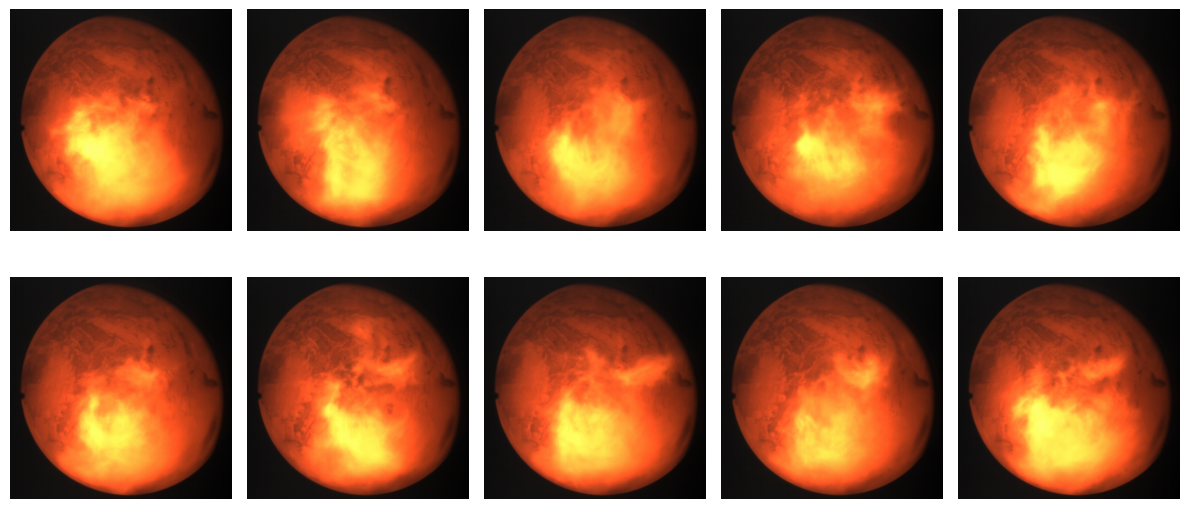

In [ ]:
meanR = np.mean(red_means)
diff_meanR = [abs(mean-meanR) for mean in red_means]

# Create a subplot grid for 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

best_10_img = np.argsort(diff_meanR)[:10]

#plot 10 best img with min diff with meanR
for i,index in enumerate(best_10_img):
    print(f'index : {index}, \tdiff_meanR : {diff_meanR[index]}, \tpath : {image_paths[index]}')
    axes[i].imshow(cv2.cvtColor(cv2.imread(image_paths[index]), cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
plt.tight_layout()
plt.show()

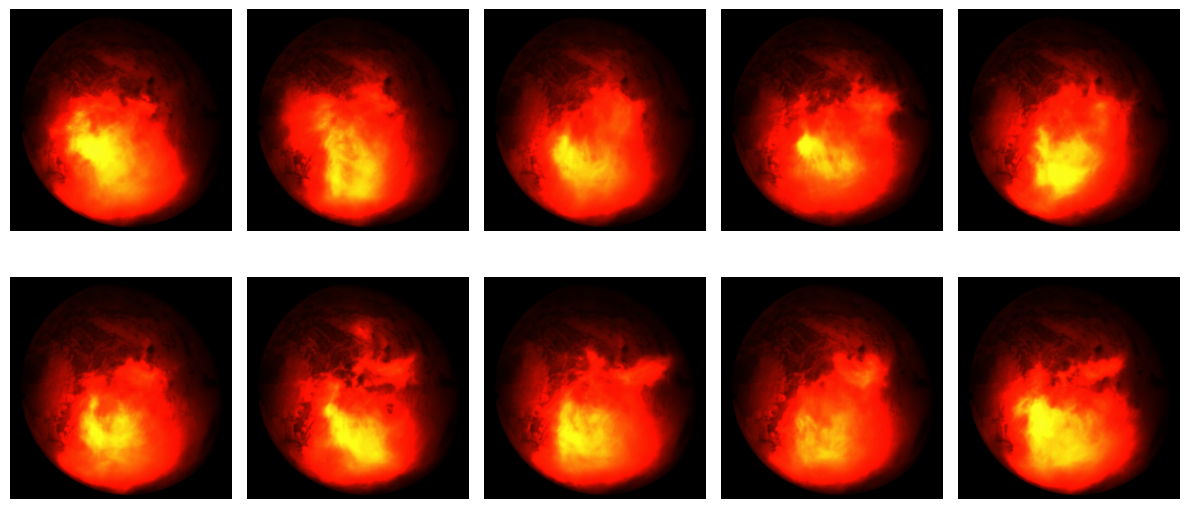

In [ ]:
def correct_gamma(image_path,G):
    image = cv2.imread(image_path)
    # Convert image to float and normalize to range 0-1
    image_normalized = image.astype(float) / 255.0

    # # # Calculate mean R intensity
    # meanRimg = np.mean(image_normalized[:, :, 2])  # Image is in BGR format
    
    # print(meanRimg)
    # # # Calculate G value
    # G = 0.74 * np.exp(-3.97 * meanRimg)
    
    # print(G)
    # Apply transformation
    transformed_image = np.power(image_normalized, 1 / G)
    img_float32 = np.float32(transformed_image)
    return img_float32

G = 0.40
corrected_images = [correct_gamma(image_paths[index],G) for index in best_10_img]

# Create a subplot grid for 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

#plot 10 best img with min diff with meanR
for i,img in enumerate(corrected_images):
    # Plot the transformed image
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [5]:
print(meanR)

128.57288923559133


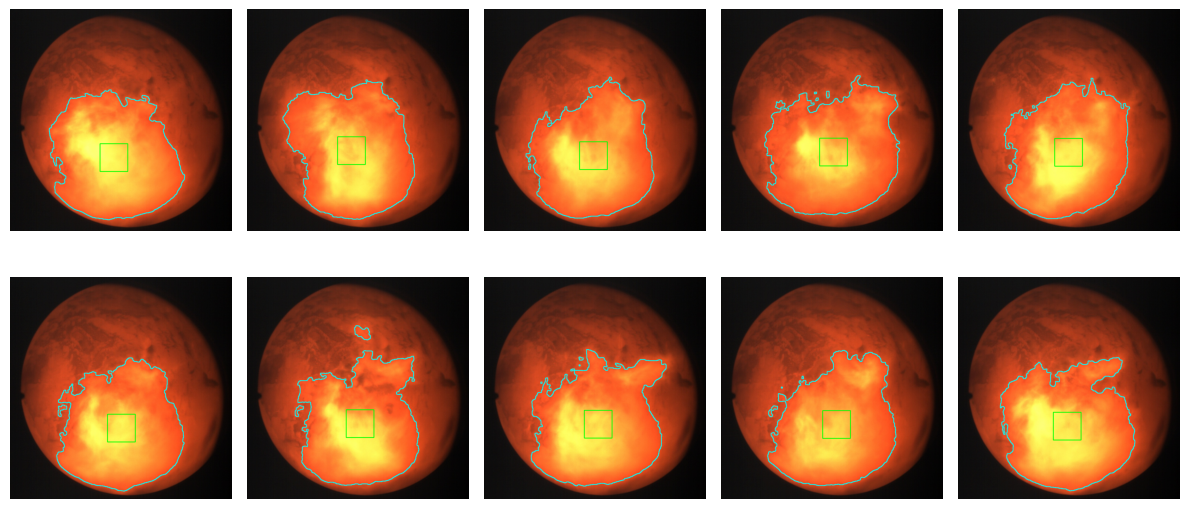

In [ ]:
def extract_ROI(original_image):
    
    # Convert to grayscale
    gray_image = cv2.cvtColor((original_image*255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    # # Apply histogram normalization
    # normalized_image = cv2.equalizeHist(gray_image)
    
    # Apply median filtering
    filtered_image = cv2.medianBlur(gray_image, 5)
    
    # Apply Otsu's thresholding
    _, thresholded_image = cv2.threshold(filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Apply morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)
    opened_image = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN, kernel)

    # Find contours in the processed image
    contours, _ = cv2.findContours(opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    
    # Calculate the moments of the contour
    M = cv2.moments(contour)
    
    # Calculate the center of the contour
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])
    
    # Calculate the coordinates of the square ROI
    roi_size = 100
    roi_x = center_x - roi_size // 2
    roi_y = center_y - roi_size // 2
    
    return {'contours':contours,'roi_x':roi_x,'roi_y':roi_y,'roi_size':roi_size}

ROIs = [extract_ROI(img) for img in corrected_images]

# Create a subplot grid for 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

#plot 10 best img with min diff with meanR
for i,ROI in enumerate(ROIs):
    # Draw contours on the original image
    original_image = cv2.cvtColor(cv2.imread(image_paths[best_10_img[i]]), cv2.COLOR_BGR2RGB)
    # Draw rectangle around the ROI on the original image
    cv2.rectangle(original_image, (ROI['roi_x'], ROI['roi_y']), (ROI['roi_x']+ROI['roi_size'], ROI['roi_y']+ROI['roi_size']), (0, 255, 0), 2)
    contour_image = cv2.drawContours(original_image, ROI['contours'], -1, (0, 255, 255), 2)
    axes[i].imshow(contour_image)
    axes[i].axis('off')
plt.tight_layout()
plt.show()


In [7]:
def correct_gamma(image_path):
    image = cv2.imread(image_path)
    # Convert image to float and normalize to range 0-1
    image_normalized = image.astype(float) / 255.0

    # Calculate mean R intensity
    meanR = np.mean(image_normalized[:, :, 2])  # Image is in BGR format
    
    # Calculate G value
    G = 0.621 * np.exp(-0.110 * meanR)
    
    # Apply transformation
    transformed_image = np.power(image_normalized, 1 / G)
    img_float32 = np.float32(transformed_image)
    return img_float32


# Define the path to dataset folder
folder_path = './images/6/250MWth'

# Collect the paths of all image files in the folder
image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith((".jpg", ".jpeg", ".png"))]

# Create a subplot grid for 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

# Plot 10 transformed images
for i in range(10):
    # Apply transformation
    transformed_image = correct_gamma(image_paths[i])
    # Plot the transformed image
    axes[i].imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: './images/6/250MWth'